## Imports

In [ ]:
from pathlib import Path
from copy import deepcopy

import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import tqdm

from ephys_atlas.plots import figure_features_chspace, plot_probe_rect, plot_probe_rect2
from ephys_atlas.encoding import voltage_features_set
from ephys_atlas.data import load_voltage_features, prepare_df_voltage

In [2]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'DejaVu Sans',
    #'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    #'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

## Constants

In [3]:
QUANTILES = [0.01, 0.1, 0.9, 0.99]
BINS = 50

## Data loading

In [4]:
local_data_path = Path('/home/cyrille/GIT/IBL/paper-ephys-atlas/data')

features = voltage_features_set()
mapping = 'Allen'
label = 'latest'

In [5]:
df_voltage, df_clusters, df_channels, df_probes = \
    load_voltage_features(local_data_path.joinpath(label), mapping=mapping)

2025-04-14 14:14:42 INFO     data.py:399  Loaded 384215 channels
2025-04-14 14:14:42 INFO     data.py:401  Remains 384215 channels after NaNs filtering


In [6]:
df_voltage = prepare_df_voltage(df_voltage, df_channels)

## Regions

In [7]:
from iblatlas.atlas import BrainRegions
br = BrainRegions()

In [8]:
beryl_ids = df_voltage.beryl_id.unique()
acronyms = br.id2acronym(beryl_ids)
idx = np.argsort(acronyms)
acronyms = acronyms[idx]
beryl_ids = beryl_ids[idx]

## Features

In [9]:
pids = df_voltage.index.get_level_values(0).unique()

In [10]:
df_voltage

rms_ap  cor_ratio     rms_lf  \
pid                                  channel                                    
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -93.322170   0.754190 -90.644629   
                                     1       -91.982491   0.411007 -90.323467   
                                     2       -91.566196   0.451987 -90.232606   
                                     3       -90.669213   0.469155 -87.667768   
                                     4       -91.297692   0.338838 -89.531428   
...                                                 ...        ...        ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -88.665620   0.788894 -86.852443   
                                     380     -88.228718   0.766668 -86.533096   
                                     381     -88.432738   0.744558 -86.795452   
                                     382     -87.946953   0.696702 -86.330790   
                                     383     -88.010332   0.695542 -86.655819   

                                               psd_delta   psd_theta  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -101.787283 -104.159496   
                                     1       -101.573927 -104.459178   
                                     2       -101.712161 -104.223009   
                                     3        -97.225263 -102.353363   
                                     4        -99.494953 -104.781015   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      -96.893853 -101.622061   
                                     380      -96.756403 -101.407902   
                                     381      -97.154323 -101.746486   
                                     382      -96.286040 -101.416863   
                                     383      -97.056808 -101.644340   

                                               psd_alpha    psd_beta  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -105.973834 -112.510019   
                                     1       -106.397486 -112.693430   
                                     2       -106.204256 -112.325320   
                                     3       -104.408635 -110.429818   
                                     4       -106.740744 -112.371962   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -104.861699 -110.253048   
                                     380     -104.768071 -110.041355   
                                     381     -104.903059 -110.157332   
                                     382     -104.826851 -109.906594   
                                     383     -105.094410 -110.118663   

                                               psd_gamma     psd_lfp  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -115.888470 -112.043098   
                                     1       -115.906262 -111.789864   
                                     2       -115.555288 -111.863034   
                                     3       -114.125412 -109.164580   
                                     4       -115.086073 -111.196320   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -113.620168 -108.627753   
                                     380     -113.450934 -108.257603   
                                     381     -113.669899 -108.536956   
                                     382     -113.303112 -108.127909   
                                     383     -113.458966 -108.403703   

                                                rms_lf_csd  ...  x_target_y  \
pid                                  channel                ...               
00a824c0-e060-495f-9ebc-79

In [11]:
df_voltage.shape

(325853, 59)

In [12]:
df_voltage.acronym

pid                                   channel
00a824c0-e060-495f-9ebc-79c82fef4c67  0          MRN
                                      1          MRN
                                      2          MRN
                                      3          MRN
                                      4          MRN
                                                ... 
ffb1b072-2de7-44a4-8115-5799b9866382  379        PRM
                                      380        PRM
                                      381        PRM
                                      382        PRM
                                      383        PRM
Name: acronym, Length: 325853, dtype: object

In [13]:
df_voltage.index.names

FrozenList(['pid', 'channel'])

In [14]:
df_voltage.index.shape

(325853,)

## Distribution plotting functions

In [15]:
def select_series_v2(df, features=None, acronym=None, id=None, mapping='Allen'):
    if features is None:  # Take the whole set
        features = voltage_features_set()
    if acronym is not None:
        series = df.loc[df[f'{mapping}_acronym'] == acronym, features]
    elif id is not None:
        series = df.loc[df[f'{mapping}_id'] == id, features]
    return series

In [16]:
def select_series(df, feature=None, acronym=None, beryl_id=None):
    if acronym is not None:
        series = df.loc[df['acronym'] == acronym, feature or features]
    elif beryl_id is not None:
        series = df.loc[df['beryl_id'] == beryl_id, feature or features]
    elif feature is not None:
        series = df[feature]
    return series

In [17]:
def plot_histogram(series, ax=None, quantiles=None, bins=None, xlabel=None, title=None):
    quantiles = quantiles if quantiles is not None else QUANTILES
    quantile_values = np.quantile(series, quantiles)

    bins = bins if bins is not None else BINS

    hist_values, bin_edges = np.histogram(series, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    color_indices = np.digitize(bin_centers, quantile_values, right=True)
    colors = cm.viridis(color_indices / color_indices.max())

    ax.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), color=colors, align='edge')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.text(
        0.95, 0.95, f"{len(series):,} samples",
        transform=ax.transAxes, ha='right', va='top', fontsize=12,
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='out', length=6)
    ax.set_facecolor('#f9f9f9')
    plt.tight_layout()

## Plots

## Channels

In [18]:
df_channels.columns

Index(['x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um',
       'x_target', 'y_target', 'z_target', 'atlas_id_target'],
      dtype='object')

In [19]:
df_channels.index.names

FrozenList(['pid', 'channel'])

In [20]:
df_channels.index.shape

(384768,)

In [21]:
df_channels.acronym

pid                                   channel
00a824c0-e060-495f-9ebc-79c82fef4c67  0          MRN
                                      1          MRN
                                      2          MRN
                                      3          MRN
                                      4          MRN
                                                ... 
ffb1b072-2de7-44a4-8115-5799b9866382  379        PRM
                                      380        PRM
                                      381        PRM
                                      382        PRM
                                      383        PRM
Name: acronym, Length: 384768, dtype: object

## Distribution comparison

In [22]:
feature = features[0]

In [37]:
features

['rms_ap',
 'rms_lf',
 'psd_delta',
 'psd_theta',
 'psd_alpha',
 'psd_beta',
 'psd_gamma',
 'alpha_mean',
 'alpha_std',
 'spike_count',
 'peak_time_secs',
 'peak_val',
 'trough_time_secs',
 'trough_val',
 'tip_time_secs',
 'tip_val',
 'polarity',
 'depolarisation_slope',
 'repolarisation_slope',
 'recovery_time_secs',
 'recovery_slope']

In [23]:
series = select_series(df_voltage, feature)
series


pid                                   channel
00a824c0-e060-495f-9ebc-79c82fef4c67  0         -93.322170
                                      1         -91.982491
                                      2         -91.566196
                                      3         -90.669213
                                      4         -91.297692
                                                   ...    
ffb1b072-2de7-44a4-8115-5799b9866382  379       -88.665620
                                      380       -88.228718
                                      381       -88.432738
                                      382       -87.946953
                                      383       -88.010332
Name: rms_ap, Length: 325853, dtype: float64

In [24]:
_, idx = br.id2index(beryl_ids, mapping="Beryl")
idx = np.array([_[0] for _ in idx])

In [25]:
colors = br.rgb[idx] / 255.0

In [26]:
df_voltage.loc[series.index]

rms_ap  cor_ratio     rms_lf  \
pid                                  channel                                    
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -93.322170   0.754190 -90.644629   
                                     1       -91.982491   0.411007 -90.323467   
                                     2       -91.566196   0.451987 -90.232606   
                                     3       -90.669213   0.469155 -87.667768   
                                     4       -91.297692   0.338838 -89.531428   
...                                                 ...        ...        ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -88.665620   0.788894 -86.852443   
                                     380     -88.228718   0.766668 -86.533096   
                                     381     -88.432738   0.744558 -86.795452   
                                     382     -87.946953   0.696702 -86.330790   
                                     383     -88.010332   0.695542 -86.655819   

                                               psd_delta   psd_theta  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -101.787283 -104.159496   
                                     1       -101.573927 -104.459178   
                                     2       -101.712161 -104.223009   
                                     3        -97.225263 -102.353363   
                                     4        -99.494953 -104.781015   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379      -96.893853 -101.622061   
                                     380      -96.756403 -101.407902   
                                     381      -97.154323 -101.746486   
                                     382      -96.286040 -101.416863   
                                     383      -97.056808 -101.644340   

                                               psd_alpha    psd_beta  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -105.973834 -112.510019   
                                     1       -106.397486 -112.693430   
                                     2       -106.204256 -112.325320   
                                     3       -104.408635 -110.429818   
                                     4       -106.740744 -112.371962   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -104.861699 -110.253048   
                                     380     -104.768071 -110.041355   
                                     381     -104.903059 -110.157332   
                                     382     -104.826851 -109.906594   
                                     383     -105.094410 -110.118663   

                                               psd_gamma     psd_lfp  \
pid                                  channel                           
00a824c0-e060-495f-9ebc-79c82fef4c67 0       -115.888470 -112.043098   
                                     1       -115.906262 -111.789864   
                                     2       -115.555288 -111.863034   
                                     3       -114.125412 -109.164580   
                                     4       -115.086073 -111.196320   
...                                                  ...         ...   
ffb1b072-2de7-44a4-8115-5799b9866382 379     -113.620168 -108.627753   
                                     380     -113.450934 -108.257603   
                                     381     -113.669899 -108.536956   
                                     382     -113.303112 -108.127909   
                                     383     -113.458966 -108.403703   

                                                rms_lf_csd  ...  x_target_y  \
pid                                  channel                ...               
00a824c0-e060-495f-9ebc-79

In [27]:
agg_funcs = {
    "median": "median",
    "std": "std",
    "min": "min",
    "max": "max",
    "q01": lambda x: x.quantile(0.01),
    "q99": lambda x: x.quantile(0.99),
}

In [28]:
df_stats_bak = {}
for agg_name, agg_func in agg_funcs.items():
    df_stat_baks[agg_name] = df_voltage.groupby("beryl_id")[features].agg(agg_func)

NameError: name 'df_stat_baks' is not defined

In [ ]:
acronyms = br.id2acronym(beryl_ids, mapping='Beryl')

## Outlier detection

In [51]:
import numpy as np
from sklearn.neighbors import KernelDensity

def detect_outliers_kde(train_data: np.ndarray, test_data: np.ndarray, kde=None):
    """
    Detects outliers in D-dimensional space using Kernel Density Estimation (KDE).

    Parameters:
    - train_data: (N, D) numpy array, training dataset (assumed to represent the true distribution).
    - test_data: (M, D) numpy array, test dataset (points to evaluate for outlier probability).

    Returns:
    - outlier_probs: (M,) numpy array, probability of each test sample being an outlier.
    """
    # If kde is set, it is assumed to be alread trained
    if not kde:
        kde = KernelDensity()
        kde.fit(train_data)
    mean_score = kde.score(train_data) / train_data.shape[0]
    out = 1 - np.exp(1-kde.score_samples(test_data) / mean_score)
    return out

In [36]:
df_voltage.describe()

,rms_ap,cor_ratio,rms_lf,psd_delta,psd_theta,psd_alpha,psd_beta,psd_gamma,psd_lfp,rms_lf_csd,...,x_target_y,y_target_y,z_target_y,atlas_id_target_y,cosmos_id,beryl_id,spike_count_log,peak_to_trough_ratio,peak_to_trough_ratio_log,peak_to_trough_duration
count,325853.000000,325853.000000,325853.000000,325853.000000,325853.000000,325853.000000,325853.000000,325853.000000,325853.000000,3.258530e+05,...,325853.000000,325853.000000,325853.000000,3.258530e+05,325853.000000,3.258530e+05,325853.000000,325853.000000,325853.000000,325853.000000
mean,-96.009721,0.387429,-87.273073,-97.521572,-101.757680,-104.947186,-109.834930,-113.696026,-108.664781,3.487836e-09,...,-0.001213,-0.001851,-0.003359,2.247150e+07,626.967817,1.672879e+07,1.599322,3.855849,1.074797,0.000396
std,3.535114,0.174793,6.018502,6.085233,7.053215,6.947147,6.251247,5.877766,6.177425,3.660158e-09,...,0.001514,0.002197,0.001539,9.856412e+07,306.561252,8.531819e+07,0.410162,50.844962,0.451518,0.000073
min,-112.809352,-6.565997,-106.573759,-118.192793,-123.572267,-126.297912,-129.854380,-132.931700,-128.000706,1.735108e-23,...,-0.005106,-0.006676,-0.008805,0.000000e+00,313.000000,4.000000e+00,0.301030,0.000330,-8.015037,0.000142
25%,-98.442188,0.254096,-91.711404,-102.026513,-107.018128,-110.105038,-114.493986,-118.033080,-113.266527,2.118871e-09,...,-0.002119,-0.003232,-0.004397,3.130000e+02,315.000000,3.100000e+02,1.322219,2.589121,0.951319,0.000344
50%,-96.480627,0.366389,-88.423175,-98.585751,-103.128853,-106.272475,-111.008808,-114.809080,-109.848528,2.539568e-09,...,-0.001377,-0.001846,-0.003374,6.720000e+02,549.000000,6.720000e+02,1.579784,2.943712,1.079671,0.000398
75%,-94.090506,0.497824,-83.626713,-93.678611,-97.274880,-100.699728,-106.128535,-110.256258,-104.865436,3.490380e-09,...,-0.000392,-0.000368,-0.002247,9.610000e+02,1065.000000,9.840000e+02,1.883661,3.308483,1.196490,0.000445
max,-75.927125,1.239223,-54.703607,-62.324811,-69.214692,-72.020700,-78.239393,-83.560927,-76.305780,3.428810e-07,...,0.003371,0.003174,0.006755,6.144543e+08,1097.000000,6.068267e+08,3.190192,16970.981110,9.739260,0.001233


In [30]:
outliers = []
for beryl_id in tqdm.tqdm(beryl_ids):
    series = select_series(df_voltage, beryl_id=beryl_id)
    train_data = series.values
    test_data = train_data
    scores = detect_outliers_kde(train_data, test_data)
    outliers.append(scores)
outliers = sorted(outliers, key=len)

100%|██████████| 288/288 [00:23<00:00, 12.27it/s]


In [47]:
for beryl_id in tqdm.tqdm(beryl_ids):
    kde = KernelDensity()
    series = select_series(df_voltage, beryl_id=beryl_id)
    kde.fit(series.values)
    joblib.dump(kde, f'kdes/kde-{beryl_id:05d}.pkl')


100%|██████████| 288/288 [00:05<00:00, 51.20it/s]


In [49]:
df_voltage.shape

(325853, 59)

In [50]:
len(features)

21

In [ ]:
def compute_mean_score(beryl_id):
    path = f'kdes/kde-{beryl_id:05d}.pkl'
    series = select_series(df_voltage, beryl_id=beryl_id)[features]
    kde = joblib.load(path)
    mean_score = kde.score(series) / series.shape[0]
    return mean_score


In [ ]:
scores = {beryl_id: compute_mean_score(beryl_id) for beryl_id in beryl_ids}

In [ ]:
joblib.dump(scores, "kdes/mean_scores.pkl")

['kdes/mean_scores.pkl']

In [104]:
class Outlier:
    def __init__(self):
        self.paths = {beryl_id: f'kdes/kde-{beryl_id:05d}.pkl' for beryl_id in beryl_ids}
        self.kdes = {key: joblib.load(path) for key, path in self.paths.items()}
        self.mean_scores = joblib.load('kdes/mean_scores.pkl')

    def outlier_region(self, beryl_id, test_data):
        #series = select_series(df_voltage, beryl_id=beryl_id)
        #train_data = series.values
        #return detect_outliers_kde(train_data, test_data, kde=self.kdes[beryl_id])
        kde = self.kdes[beryl_id]
        return 1 - np.exp(1-kde.score_samples(test_data) / self.mean_scores[beryl_id])

    def outliers(self, test_data, region_ids):
        n = test_data.shape[0]
        unique_regions = np.unique(region_ids)
        outliers = np.zeros(n)
        for beryl_id in unique_regions:
            idx = region_ids == beryl_id
            test_data_region = test_data[idx]
            outliers[idx] = self.outlier_region(beryl_id, test_data_region)
        return outliers

In [68]:
pid = "b72b22c2-6e9d-4604-9910-20c0e1a467d7"

In [83]:
channel_regions = br.id2id(df_voltage.loc[(pid,)].Allen_id, "Beryl")

In [108]:
test_data = df_voltage.loc[(pid,), features]

In [109]:
ou = Outlier()

In [110]:
outliers = ou.outliers(test_data, channel_regions)

/home/cyrille/GIT/IBL/paper-ephys-atlas/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(
/home/cyrille/GIT/IBL/paper-ephys-atlas/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(
/home/cyrille/GIT/IBL/paper-ephys-atlas/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(
/home/cyrille/GIT/IBL/paper-ephys-atlas/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KernelDensity was fitted without feature names
  warnings.warn(


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   2.,  93., 118.]),
 array([-1.06581410e-14, -1.04383169e-14, -1.02184927e-14, -9.99866856e-15,
        -9.77884440e-15, -9.55902024e-15, -9.33919608e-15, -9.11937192e-15,
        -8.89954777e-15, -8.67972361e-15, -8.45989945e-15, -8.24007529e-15,
        -8.02025113e-15, -7.80042697e-15, -7.58060281e-15, -7.36077865e-15,
        -7.14095449e-15, -6.92113034e-15, -6.70130618e-15, -6.48148202e-15,
        -6.26165786e-15, -6.04183370e-15, -5.82200954e-15, -5.60218538e-15,
        -5.38236122e-15, -5.16253706e-15, -4.94271291e-15, -4.72288875e-15,
        -4.50306459e-15, -4.28324043e-15, -4.06341627e-15, -3.84359211e-15,
        -3.62376795e-15, -3.40394379e-15, -3.18411

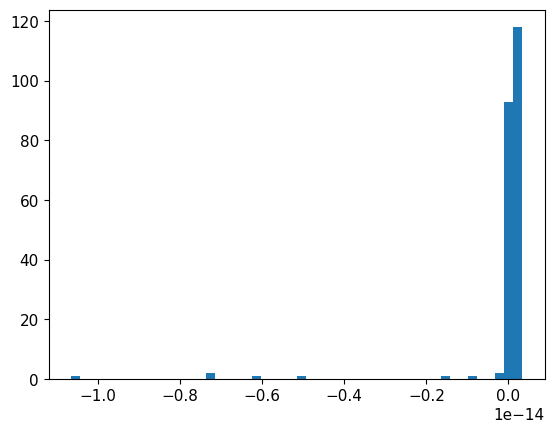

In [114]:
plt.hist(outliers, 50)

In [56]:
beryl_id = beryl_ids[40]
ou.outlier(beryl_id, select_series(df_voltage, beryl_id=beryl_id).values)

array([1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       1.11022302e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
      

In [31]:
n = len(outliers[-1])

In [32]:
outliers_arr = np.zeros((len(beryl_ids), n), dtype=np.float32)
for outlier in outliers:
    outliers_arr[i, :len(outlier)] = outlier

NameError: name 'i' is not defined

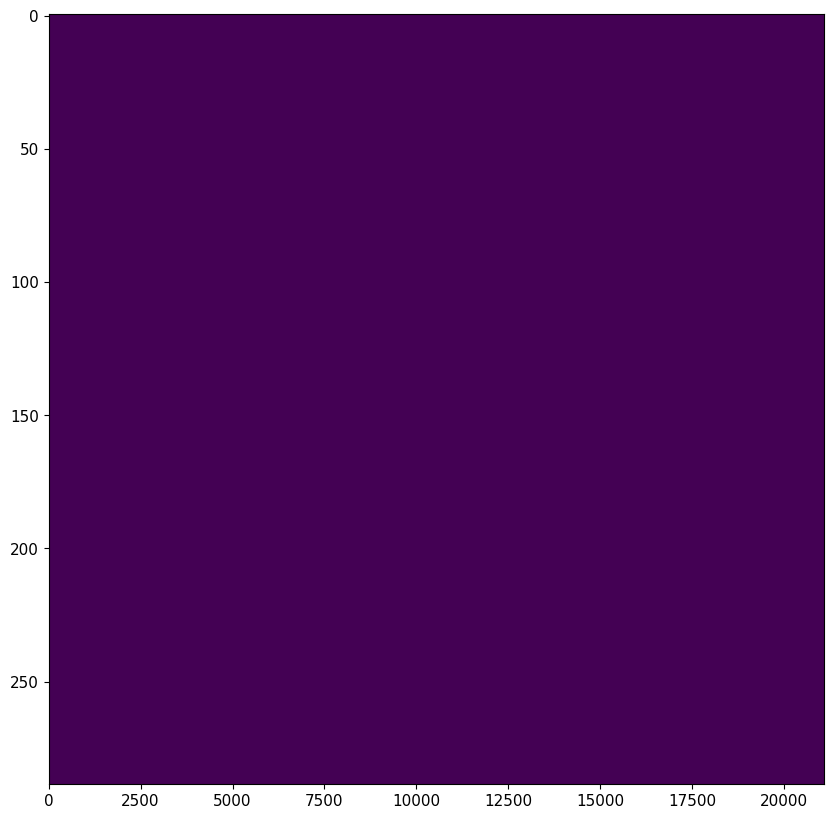

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(outliers_arr[:, :], vmin=0, vmax=1, interpolation='none', aspect='auto')